In [1]:
# encoding: utf-8 
from __future__ import unicode_literals
import cartopy.crs as ccrs
from cartopy.io import shapereader
import ibm_db
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy import stats
import multiprocessing

from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.sql import types as T
from pyspark.sql import functions as F
from pyspark.conf import SparkConf

from my_utils.utils import do_spark_query as dsq

%matplotlib inline

In [2]:
# create SparkContext and SparkSession to process files
cores = multiprocessing.cpu_count() - 2

conf = SparkConf()
conf.setMaster('local[' + str(cores) + ']') \
    .setAppName('example') \
    .set('spark.serializer', 'org.apache.spark.serializer.KryoSerializer') \
    .set('spark.driver.memory', '8g')

sc = SparkContext(conf=conf)
spark = SparkSession(sc)

In [3]:
my_path = '../data/'

In [4]:
ceps = spark.read.format('csv') \
    .option('sep', ',') \
    .option('header', 'True') \
    .option('inferSchema', 'True') \
    .load(my_path + 'precos_ceps.csv')
ceps.createOrReplaceTempView("tab_ceps")

In [5]:
ceps.columns

['cep',
 'bairro',
 'municipio',
 'uf',
 'm2',
 'm2_imputado',
 'preco',
 'preco_imputado']

In [6]:
estados = spark.read.format('csv') \
    .option('sep', ',') \
    .option('header', 'True') \
    .option('inferSchema', 'True') \
    .load(my_path + 'estados.csv')
estados.createOrReplaceTempView("tab_estados")
estados.columns

['uf', 'estado']

In [7]:
ceps = dsq(spark, """
    select a.*
         , b.estado
    from tab_ceps a, tab_estados b
    where a.uf = b.uf
""")
ceps.createOrReplaceTempView("tab_ceps")
ceps.columns

['cep',
 'bairro',
 'municipio',
 'uf',
 'm2',
 'm2_imputado',
 'preco',
 'preco_imputado',
 'estado']

In [8]:
det = spark.read.format('csv') \
    .option('sep', ',') \
    .option('header', 'True') \
    .option('inferSchema', 'True') \
    .load(my_path + 'detalhes_imoveis.csv')
det.createOrReplaceTempView("tab_det")
det.columns

['cd_pss', 'cep', 'cd_sgm', 'vl_rend', 'vl_mgct_obsd']

In [9]:
app = spark.read.format('csv') \
    .option('sep', ',') \
    .option('header', 'True') \
    .option('inferSchema', 'True') \
    .load(my_path + 'dados_mov.csv')
app.createOrReplaceTempView("tab_app")

In [10]:
app_state = dsq(spark, """
    select state
         , avg(m2) as m2
         , avg(house_price) as house_price
         , avg(m2_price) as m2_price
         , avg(income) as income
         , avg(margin) as margin
    from (
            select a.estado as state
                 , a.m2_imputado as m2
                 , a.preco_imputado as house_price
                 , a.preco_imputado / float(a.m2_imputado) as m2_price
                 , b.vl_rend as income
                 , b.vl_mgct_obsd as margin
            from tab_ceps a
               , tab_det  b
               , tab_app  c
            where a.cep    = b.cep
              and b.cd_pss = c.cd_pss )
    group by state
    order by state
""").toPandas()

In [11]:
digi = spark.read.format('csv') \
    .option('sep', ',') \
    .option('header', 'True') \
    .option('inferSchema', 'True') \
    .load(my_path + 'dados_digi.csv')
digi.createOrReplaceTempView("tab_digi")

In [12]:
digi_state = dsq(spark, """
    select state
         , avg(m2) as m2
         , avg(house_price) as house_price
         , avg(m2_price) as m2_price
         , avg(margin) as margin
    from (
            select a.estado as state
                 , a.m2_imputado as m2
                 , a.preco_imputado as house_price
                 , a.preco_imputado / float(a.m2_imputado) as m2_price
                 , b.vl_mgct_obsd as margin
            from tab_ceps a
               , tab_det  b
               , tab_digi c
            where a.cep    = b.cep
              and b.cd_pss = c.cd_pss )
    group by state
    order by state
""").toPandas()

In [13]:
kw = dict(resolution='50m', category='cultural',
          name='admin_1_states_provinces')

states_shp = shapereader.natural_earth(**kw)
shp = shapereader.Reader(states_shp)

In [14]:
def heat_map(states, values, vmin=None, vmax=None, label=None):
    if not vmin:
        vmin = np.min(values)
        
    if not vmax:
        vmax = np.max(values) * 1.1

    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    cmap = cm.hot_r
    m = cm.ScalarMappable(norm=norm, cmap=cmap)

    subplot_kw = dict(projection=ccrs.PlateCarree())

    fig, ax = plt.subplots(figsize=(10, 5),
                           subplot_kw=subplot_kw)
    ax.set_extent([-82, -32, -35, 6])

    ax.background_patch.set_visible(False)
    ax.outline_patch.set_visible(False)

    for record, state in zip(shp.records(), shp.geometries()):
        name = record.attributes['name'] 

        value = 0
        for i in range(len(values)):
            if name == states[i].encode('utf-8'):
                value = values[i]
                break
        if value == 0:
            facecolor = 'LightGray'
        else:
            facecolor = m.to_rgba(value)
        ax.add_geometries([state], ccrs.PlateCarree(),
                          facecolor=facecolor, edgecolor='black')

    if label:
        m._A = []
        plt.colorbar(m, ax=ax, shrink=.5).set_label(label)

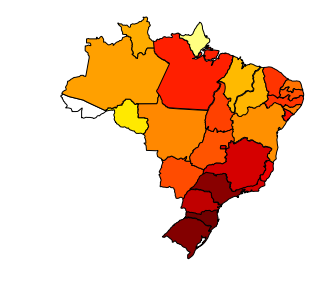

In [15]:
heat_map(app_state['state'], app_state['house_price'])

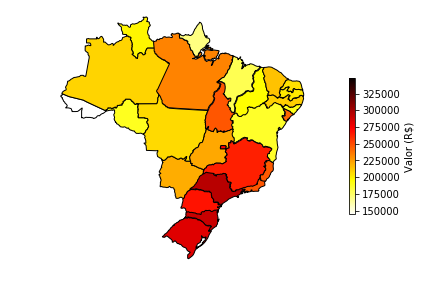

In [16]:
vmin = np.min(app_state['house_price'])
vmax = np.max(app_state['house_price']) * 1.1

heat_map(digi_state['state'], digi_state['house_price'], vmin=vmin, vmax=vmax, label='Valor (R$)')

In [17]:
app_state_high = dsq(spark, """
    select state
         , avg(m2) as m2
         , avg(house_price) as house_price
         , avg(m2_price) as m2_price
         , avg(income) as income
         , avg(margin) as margin
    from (
            select a.estado as state
                 , a.m2_imputado as m2
                 , a.preco_imputado as house_price
                 , a.preco_imputado / float(a.m2_imputado) as m2_price
                 , b.vl_rend as income
                 , b.vl_mgct_obsd as margin
            from tab_ceps a
               , tab_det  b
               , tab_app  c
            where a.cep    = b.cep
              and b.cd_pss = c.cd_pss
              and b.vl_rend >= 10000)
    group by state
    order by state
""").toPandas()

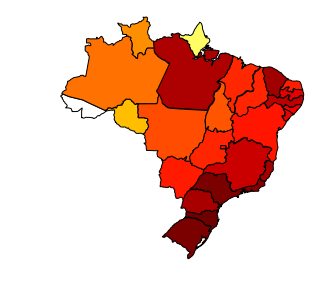

In [18]:
heat_map(app_state_high['state'], app_state_high['house_price'])

In [19]:
app_state_low = dsq(spark, """
    select state
         , avg(m2) as m2
         , avg(house_price) as house_price
         , avg(m2_price) as m2_price
         , avg(income) as income
         , avg(margin) as margin
    from (
            select a.estado as state
                 , a.m2_imputado as m2
                 , a.preco_imputado as house_price
                 , a.preco_imputado / float(a.m2_imputado) as m2_price
                 , b.vl_rend as income
                 , b.vl_mgct_obsd as margin
            from tab_ceps a
               , tab_det  b
               , tab_app  c
            where a.cep    = b.cep
              and b.cd_pss = c.cd_pss
              and b.vl_rend < 10000)
    group by state
    order by state
""").toPandas()

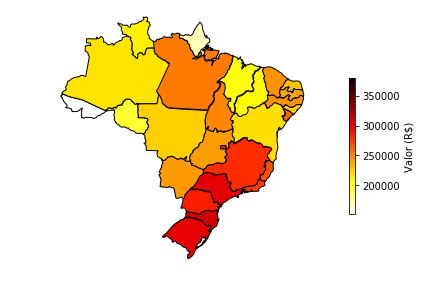

In [20]:
vmin = np.min(app_state_high['house_price'])
vmax = np.max(app_state_high['house_price']) * 1.1

heat_map(app_state_low['state'], app_state_low['house_price'], vmin=vmin, vmax=vmax, label='Valor (R$)')

In [21]:
cli_cel = spark.read.format('csv') \
    .option('sep', ';') \
    .option('header', 'True') \
    .option('inferSchema', 'True') \
    .load(my_path + 'marcamodelosopreco.csv')
cli_cel.createOrReplaceTempView("tab_cel")

In [23]:
app_so = dsq(spark, """
    select os
         , count(*) as qty
    from (
            select case a.nm_so
                    when 'WINDOWS8' then 'Windows' 
                    when 'WINDOWSPHONE' then 'Windows'
                    when 'IPHONE' then  'iOS'
                    when 'ANDROID' then 'Android'
                   end as os
            from tab_cel a
               , tab_app b
            where a.mci = b.cd_pss 
              and a.nm_so is not null )
    group by os
""").toPandas()

In [24]:
digi_so = dsq(spark, """
    select os
         , count(*) as qty
    from (
            select case a.nm_so
                    when 'WINDOWS8' then 'Windows' 
                    when 'WINDOWSPHONE' then 'Windows'
                    when 'IPHONE' then  'iOS'
                    when 'ANDROID' then 'Android'
                   end as os
            from tab_cel a
               , tab_digi b
            where a.mci = b.cd_pss
              and a.nm_so is not null )
    group by os
""").toPandas()

In [25]:
app_so['norm'] = app_so.apply(lambda x : 100 * x['qty'] / float(np.sum(app_so['qty'])), axis=1)

In [26]:
digi_so['norm'] = digi_so.apply(lambda x : 100 * x['qty'] / float(np.sum(digi_so['qty'])), axis=1)

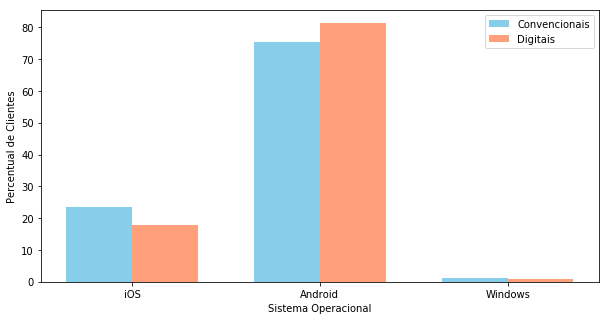

In [27]:
ind = np.arange(len(app_so))
width = 0.35       # the width of the bars

fig, ax = plt.subplots(figsize=(10, 5))
rects1 = ax.bar(ind, app_so['norm'], width, color='skyblue')
rects2 = ax.bar(ind + width, digi_so['norm'], width, color='lightsalmon')

ax.set_ylabel('Percentual de Clientes')
ax.set_xlabel('Sistema Operacional')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(app_so['os'])

ax.legend((rects1[0], rects2[0]), ('Convencionais', 'Digitais'))


plt.show()

In [28]:
app_phone = dsq(spark, """
    select a.media
    from tab_cel a
       , tab_app b
    where a.mci = b.cd_pss
""").toPandas()

In [29]:
digi_phone = dsq(spark, """
    select a.media
    from tab_cel a
       , tab_digi b
    where a.mci = b.cd_pss
""").toPandas()

/usr/local/lib/python2.7/dist-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


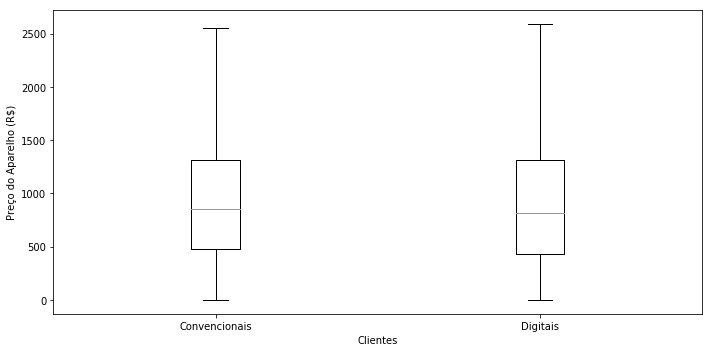

In [30]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.boxplot(x=[app_phone, digi_phone],
           showfliers=False,
           labels=['Convencionais', 'Digitais'])

ax.set_ylabel(u'Preço do Aparelho (R$)')
ax.set_xlabel(u'Clientes')

fig.tight_layout()
fig.show()  

In [31]:
sc.stop()